# DCGAN for generating faces

## Imports

In [28]:
from tensorflow.keras.datasets import mnist
import cv2
from datetime import datetime
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import os
from PIL import Image
import math
import yaml
from copy import deepcopy
import glob
import imageio
import time
import io
from shutil import copyfile
import gdown
from IPython import display
from zipfile import ZipFile
from tqdm.notebook import tqdm
import warnings
from keras.applications.inception_v3 import InceptionV3
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

## Paths

In [29]:
base_path = "."
path_to_faces_data = "celeba_gan"
data_directory_faces = "celeba_gan/img_align_celeba"

## Download data

And manually ```unzip``` in terminal.

In [30]:
os.makedirs(path_to_faces_data)
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = os.path.join(path_to_faces_data, "data.zip")
gdown.download(url, output, quiet=False)

FileExistsError: [Errno 17] File exists: 'celeba_gan'

## Check hardware resources

In [31]:
print(f"TF version: {tf.__version__}")
print(f"GPUs used: {tf.config.list_physical_devices('GPU')}")

TF version: 2.4.1
GPUs used: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
!nvidia-smi

Sat May 22 17:14:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    39W / 300W |  15729MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data pipeline

In [33]:
def data_pipeline_load(dataset_name, **kwargs):
    """ Create optimized data loading pipeline for training.
    Adapted from: https://cs230.stanford.edu/blog/datapipeline/,
    https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data
    
    Parameters
    ----------
    dataset_name : str
        Name of dataset, either mnist or faces.
    kwargs : dict
        Must include resize_to for both mnist and faces. 
        Must include data_directory for faces.
        If resize_to is None, the images keep their original shapes.
        Must include reduce_to (reduce dataset size). If None, all of the
        dataset is used.
    
    Returns
    -------
    dataset : tf.data.Dataset
        Dataset object.
    dataset_size : int
        Number of instances in dataset. For shuffling later.
    
    Raises
    ------
    None
    
    Notes
    -----
    Dataset is not pre-processed, shuffled, not batched. 
    and not pre-fetched yet.
    """
    resize_to = kwargs["resize_to"]
    normalizer = kwargs["normalizer"]
    reduce_to = kwargs["reduce_to"]
    
    # load dataset. dataset is shuffled
    if dataset_name == "mnist":
        dataset, dataset_size, img_original_shape = \
          data_pipeline_load_mnist(reduce_to)
    elif dataset_name == "faces":
        data_directory= kwargs["data_directory"]
        dataset, dataset_size, img_original_shape = \
          data_pipeline_load_faces(data_directory, reduce_to)
    
    # if resize_to is None, keep original image shape
    resize_to = img_original_shape if resize_to is None else resize_to
    # pre-process dataset
    dataset = data_pipeline_pre_process(dataset, normalizer, resize_to)
    print(f"loaded and pre-processed: {dataset_name}, size: {dataset_size}")
    
    return dataset, dataset_size


def data_pipeline_pre_process(dataset, normalizer, resize_to):
    """ Create optimized data pre-processing pipeline for training.
    Adapted from: https://cs230.stanford.edu/blog/datapipeline/,
    https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data
    
    Parameters
    ----------
    dataset_name : str
        Name of dataset, either mnist or faces.
    resize_to : tuple
        Resize to (height, width).
    
    Returns
    -------
    dataset : tf.data.Dataset
        Dataset object.
    
    Raises
    ------
    None
    
    Notes
    -----
    Dataset is pre-processed - standardized to -1.0 - 1.0 (for tanh) 
    and resized, or to 0.0-1.0 (sigmoid)
    Dataset is shuffled, but not batched and not pre-fetched yet.
    """
    # automatically finds good allocation of CPU budget
    dataset = dataset.map(normalizer, 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # automatically finds good allocation of CPU budget
    dataset = dataset.map(lambda im: resize_image(im, resize_to), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset


def data_pipeline_pre_train(dataset, dataset_size, batch_size, fid_split):
    """ Create optimized pre-training data pipeline. Shuffle, batch, and pre-fetch dataset.
    Adapted from: https://cs230.stanford.edu/blog/datapipeline/,
    https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data
    
    Parameters
    ----------
    dataset : tf.data.Dataset
        Dataset object.
    dataset_size : int
        Number of instances in dataset. For shuffling.
    batch_size : int 
        Batch size.
    fid_split : float
      Percentage of dataset to use for FID score.
    
    Returns
    -------
    dataset : tensorflow.data.Dataset
        Dataset object.
    
    Raises
    ------
    None
    
    Notes
    -----
    Dataset is now pre-processed, shuffled, batched and pre-fetched yet.
    buffer_size (dataset_size) >= batch_size to get an uniform shuffle, right? idk
    """
    # fid-train split
    assert 0.0 <= fid_split <= 1.0
    fid_size = int(fid_split * dataset_size)
    dataset_size = dataset_size - fid_size
    dataset_fid = dataset.take(fid_size)
    dataset = dataset.skip(fid_size)
    print(f"dataset: {len(dataset)}, dataset_fid: {len(dataset_fid)}")
  
    # dont shuffe here as it makes training extremely slow (already shuffled)
    # do batching and pre-fetch here, dataset is already shuffled in load
    # functions
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset_fid = dataset_fid.batch(batch_size)
    dataset_fid = dataset_fid.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset, dataset_size, dataset_fid, fid_size


def resize_image(image, resize_to):
    """ Resize image.
    
    Parameters
    ----------
    image : tensorflow.Tensor
        Image object.
    resize_to : tuple
        Resize to (height, width).
    
    Returns
    -------
    resized_image : tensorflow.Tensor
        Resize image object.
    
    Raises
    ------
    None
    
    Notes
    -----
    None
    """
    resized_image = tf.image.resize(image, [resize_to[0], resize_to[1]])
    return resized_image


def data_pipeline_load_mnist(reduce_to=None):
    """ MNIST loading pipeline.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    dataset : tf.data.Dataset
        Dataset object.
    dataset_size : int
        Number of instances in dataset. For shuffling.
    reduce_to : int or None
      Reduce the dataset to this many images. If None, the original dataset
      size is used.
    
    Raises
    ------
    None
    
    Notes
    -----
    Dataset is shuffled with buffer size = dataset size (full random shuffle).
    """
    (x_train, y_train), (_, _) = mnist.load_data()
    
    img_original_shape = (28, 28)
    x_train = x_train.reshape(x_train.shape[0], 
                              img_original_shape[0], 
                              img_original_shape[1], 1).astype('float32')
    
    # if needed, reduce dataset size
    if reduce_to is not None:
      x_train = x_train[:reduce_to]
    
    #make dataset
    dataset = tf.data.Dataset.from_tensor_slices(x_train)
    
    # shuffle here since more difficult later
    dataset_size = len(x_train)
    dataset = dataset.shuffle(dataset_size)
    
    return dataset, dataset_size, img_original_shape


def get_faces_paths(data_directory):
    """ Get the paths to the faces images.
    
    Parameters
    ----------
    data_directory : str
        Path to the faces images.
    
    Returns
    -------
    paths_faces : list
        List of paths to all images.
    
    Raises
    ------
    None
    
    Notes
    -----
    None
    """
    paths_faces = []
        
    for idx, filename in enumerate(os.listdir(data_directory)):
        paths_face = os.path.join(data_directory, filename)
        paths_faces.append(paths_face)
    
    return paths_faces


def parse_function(filename):
    """ Parse a filename and load the corresponding image. Used for faces.
    
    Parameters
    ----------
    filename : str
        Path to the faces image.
    
    Returns
    -------
    image : tensorflow.Tensor
        Image object.
    
    Raises
    ------
    None
    
    Notes
    -----
    None
    """
    image_string = tf.io.read_file(filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    #This will convert to float values in [0, 1], so do not use it here.
    # we normalize later.
    #image = tf.image.convert_image_dtype(image, tf.float32)

    return image

def data_pipeline_load_faces(data_directory, reduce_to=None):
    """ Faces loading pipeline.
    
    Parameters
    ----------
    data_directory : str
        Path to the faces images.
    
    Returns
    -------
    dataset : tf.data.Dataset
        Dataset object.
    dataset_size : int
        Number of instances in dataset. For shuffling.
    
    Raises
    ------
    None
    
    Notes
    -----
    Dataset is shuffled with buffer size = dataset size (full random shuffle).
    """
    # get paths to images
    filenames = get_faces_paths(data_directory)
    
    # reduce dataset size if needed
    if reduce_to is not None:
        filenames = filenames[:reduce_to]
      
    dataset_size = len(filenames)
    
    # get original image shape
    img = cv2.imread(filenames[0])
    img_original_shape = img.shape[:2]
    
    # make dataset
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    # Shuffle dataset here (paths, not images, helps RAM)
    dataset = dataset.shuffle(dataset_size)
    # parse paths to images
    dataset = dataset.map(parse_function, 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset, dataset_size, img_original_shape


def image_normalizer(typ="tanh"):
    """ Normalize images. Either for sigmoid or tanh activation.
    sigmoid is x/255.0 to be bewteen 0.0-1.0.
    tanh is (x-127.5)/127.5 to be between -1.0-1.0.
    
    Parameters
    ----------
    typ : str
        Type of activation function to normalize for.
    
    Returns
    -------
    normalizer : tf.Rescaling
      The image normalizer. Will be mapped to each image in dataset.
    
    Raises
    ------
    None
    
    Notes
    -----
    None
    """
    assert typ in ["tanh", "sigmoid"], f"invalid image normalizer"
    if typ == "tanh":
      normalizer = \
        tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, 
                                                             offset=-1)
    else:
      normalizer = \
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)

    return normalizer


def image_rescaler(typ="tanh"):
    """ Inverse Normalize (rescale) images. 
    Either for sigmoid or tanh activation.
    sigmoid is x/255.0 to be bewteen 0.0-1.0.
    tanh is (x-127.5)/127.5 to be between -1.0-1.0.
    
    Parameters
    ----------
    typ : str
        Type of activation function to normalize for.
    
    Returns
    -------
    rescaler : tf.Rescaling
      The image rescaler. Will be mapped to each image for visualization
      purposes.
    
    Raises
    ------
    None
    
    Notes
    -----
    None
    """
    assert typ in ["tanh", "sigmoid"], f"invalid image rescaler"
    if typ == "tanh":
      rescaler = lambda image: (image.numpy() * 127.5 + 127.5).astype("int32")
    else:
      rescaler = lambda image: (image.numpy() * 255.0).astype("int32")

    return rescaler

## Visualize the Faces dataset

loaded and pre-processed: faces, size: 60000
<ParallelMapDataset shapes: (32, 32, 3), types: tf.float32>


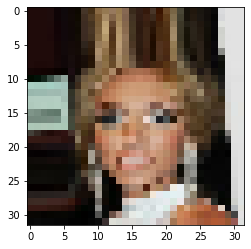

(32, 32, 3)
tf.Tensor(0.9086245, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


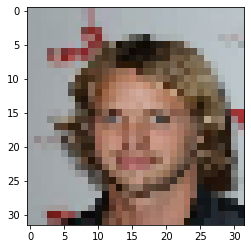

(32, 32, 3)
tf.Tensor(0.6524511, shape=(), dtype=float32)
tf.Tensor(-0.97079504, shape=(), dtype=float32)
dataset: 59000, dataset_fid: 1000
dataset: 59000, dataset_fid: 1000


In [34]:
# original shape = (218, 178, 3)
resize_to = (32, 32)
image_normalizer_typ = "tanh"
normalizer_faces = image_normalizer(image_normalizer_typ)
rescaler_faces = image_rescaler(image_normalizer_typ)

kwargs = {"data_directory": data_directory_faces, 
          "resize_to": resize_to,
          "reduce_to": 60000,
          #"reduce_to": None,
          "normalizer": normalizer_faces}

dataset_name = "faces"
batch_size = 16

# load dataset. pre-processed and shuffled, but not batched and pre-fetched.
dataset, dataset_size = data_pipeline_load(dataset_name, **kwargs)

print(dataset)

# visualize a couple of images
n_viz = 2
for image in dataset.take(n_viz):
    plt.imshow(rescaler_faces(image))
    plt.show()
    print(image.shape)
    print(tf.reduce_max(image))
    print(tf.reduce_min(image))
    
dataset, dataset_size, dataset_fid, fid_size = \
  data_pipeline_pre_train(dataset, dataset_size, batch_size, fid_split=0.01667)
print(f"dataset: {dataset_size}, dataset_fid: {fid_size}")

## Visualize the MNIST dataset

loaded and pre-processed: mnist, size: 60000
<ParallelMapDataset shapes: (28, 28, 1), types: tf.float32>


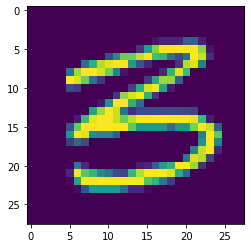

(28, 28, 1)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


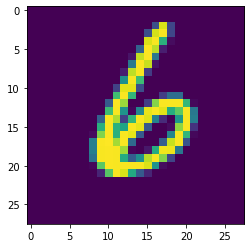

(28, 28, 1)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


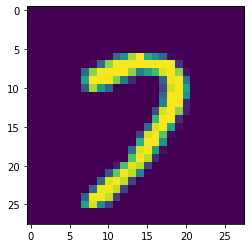

(28, 28, 1)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)


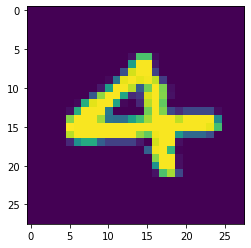

(28, 28, 1)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
dataset: 60000, dataset_fid: 0
dataset: 60000, dataset_fid: 0


In [35]:
# original shape = (28, 28, 1)
resize_to = None
image_normalizer_typ = "tanh"
normalizer_mnist = image_normalizer(image_normalizer_typ)
rescaler_mnist = image_rescaler(image_normalizer_typ)

kwargs = {"data_directory": None, 
          "resize_to": resize_to,
          "reduce_to": None,
          "normalizer": normalizer_mnist}
dataset_name = "mnist"
batch_size = 64

dataset, dataset_size = data_pipeline_load(dataset_name, **kwargs)

print(dataset)

n_viz = 4
for image in dataset.take(n_viz):
    plt.imshow(rescaler_mnist(image[:,:,0]))
    plt.show()
    print(image.shape)
    print(tf.reduce_max(image))
    print(tf.reduce_min(image))
    
dataset, dataset_size, dataset_fid, fid_size = \
  data_pipeline_pre_train(dataset, dataset_size, batch_size, fid_split=0.0)
print(f"dataset: {dataset_size}, dataset_fid: {fid_size}")

## DCGAN for MNIST

In [36]:
def make_generator_1_mnist(input_shape, output_shape):
    """ Make the generator model.

    Parameters
    ----------
    input_shape : tuple
        Input latent vector shape: (latent_dim, )
    output_shape : tuple
        Output image shape: (height, width, channels)

    Returns
    -------
    keras.Model
        The generator model.

    Raises
    ------
    None

    Notes
    -----
    source: https://www.tensorflow.org/tutorials/generative/dcgan
    pair: make_discriminator_1_mnist
    note: output_shape = (28,28,1)
    """
    inputs = keras.Input(shape=input_shape, name="generator_input")

    z_proj = layers.Dense(7*7*256, use_bias=False, name="g_h0_lin")(inputs)
    h = layers.BatchNormalization(name="g_h0_lin_bn")(z_proj)
    h = layers.LeakyReLU(name="g_h0_lin_a")(h)
    h = layers.Reshape((7, 7, 256), name="g_h0_a")(h)
    # Note: None is the batch size
    assert tuple(h.shape) == (None, 7, 7, 256)

    h = layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), 
                                     strides=(1, 1), padding='same', 
                                     use_bias=False, name="g_h1")(h)
    h = layers.BatchNormalization(name="g_h1_bn")(h)
    h = layers.LeakyReLU(name="g_h1_a")(h)
    assert tuple(h.shape) == (None, 7, 7, 128)

    h = layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), 
                                     strides=(2, 2), padding='same', 
                                     use_bias=False, name="g_h2")(h)
    h = layers.BatchNormalization(name="g_h2_bn")(h)
    h = layers.LeakyReLU(name="g_h2_a")(h)
    assert tuple(h.shape) == (None, 14, 14, 64)

    h = layers.Conv2DTranspose(filters=1, kernel_size=(5, 5), 
                               strides=(2, 2), padding='same', 
                               use_bias=False, name="g_h3_a",
                               activation='tanh')(h)
    assert tuple(h.shape) == (None, 28, 28, 1)

    generator = tf.keras.Model(inputs=inputs, outputs=h, name="generator")

    return generator


def make_discriminator_1_mnist(output_shape):
    """ Make the discriminator model.

    Parameters
    ----------
    output_shape : tuple
        Output image shape, height, width, channels.

    Returns
    -------
    keras.Model
        The discriminator model.

    Raises
    ------
    None

    Notes
    -----
    source: https://www.tensorflow.org/tutorials/generative/dcgan
    pair: make_generator_1_mnist
    note: output_shape = (28,28,1)
    """
    outputs = keras.Input(shape=output_shape, name="discriminator_input")
    
    h = layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), 
                      padding='same', name="d_h0")(outputs)
    h = layers.LeakyReLU(alpha=0.3)(h)
    h = layers.Dropout(rate=0.3)(h)

    h = layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), 
                      padding='same', name="d_h1")(h)
    h = layers.LeakyReLU(alpha=0.3)(h)
    h = layers.Dropout(rate=0.3)(h)

    h = layers.Flatten(name="d_h2_lin")(h)
    h = layers.Dense(units=1)(h)
    
    discriminator = tf.keras.Model(inputs=outputs, outputs=h, 
                                   name="discriminator")

    return discriminator

## DCGAN for Faces

In [37]:
def make_generator_1_faces(input_shape, output_shape):
    """ Make the generator model.

    Parameters
    ----------
    input_shape : tuple
        Input latent vector shape: (latent_dim, )
    output_shape : tuple
        Output image shape: (height, width, channels)

    Returns
    -------
    keras.Model
        The generator model.

    Raises
    ------
    None

    Notes
    -----
    code based on: https://www.tensorflow.org/tutorials/generative/dcgan
    model: the paper
    pair: make_discriminator_1_faces
    note: output_shape = (64,64,3)
    """
    alpha = 0.3

    inputs = keras.Input(shape=input_shape, name="generator_input")

    z_proj = layers.Dense(4*4*1024, use_bias=False, name="g_h0_lin")(inputs)
    h = layers.BatchNormalization(name="g_h0_lin_bn")(z_proj)
    h = layers.LeakyReLU(alpha=alpha, name="g_h0_lin_a")(h)
    h = layers.Reshape((4, 4, 1024), name="g_h0_a")(h)
    # Note: None is the batch size
    assert tuple(h.shape) == (None, 4, 4, 1024)

    h = layers.Conv2DTranspose(filters=512, kernel_size=(5, 5), 
                                     strides=(2, 2), padding='same', 
                                     use_bias=False, name="g_h1")(h)
    h = layers.BatchNormalization(name="g_h1_bn")(h)
    h = layers.LeakyReLU(alpha=alpha, name="g_h1_a")(h)
    assert tuple(h.shape) == (None, 8, 8, 512)

    h = layers.Conv2DTranspose(filters=256, kernel_size=(5, 5), 
                                     strides=(2, 2), padding='same', 
                                     use_bias=False, name="g_h2")(h)
    h = layers.BatchNormalization(name="g_h2_bn")(h)
    h = layers.LeakyReLU(alpha=alpha, name="g_h2_a")(h)
    assert tuple(h.shape) == (None, 16, 16, 256)



    h = layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), 
                                     strides=(2, 2), padding='same', 
                                     use_bias=False, name="g_h3")(h)
    h = layers.BatchNormalization(name="g_h3_bn")(h)
    h = layers.LeakyReLU(alpha=alpha, name="g_h3_a")(h)
    assert tuple(h.shape) == (None, 32, 32, 128)

    h = layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), 
                               strides=(2, 2), padding='same', 
                               use_bias=False, name="g_h4_a",
                               activation='tanh')(h)
    assert tuple(h.shape) == (None, 64, 64, 3)

    generator = tf.keras.Model(inputs=inputs, outputs=h, name="generator")

    return generator


def make_discriminator_1_faces(output_shape):
    """ Make the discriminator model.

    Parameters
    ----------
    output_shape : tuple
        Output image shape, height, width, channels.

    Returns
    -------
    keras.Model
        The discriminator model.

    Raises
    ------
    None

    Notes
    -----
    code based on: https://www.tensorflow.org/tutorials/generative/dcgan
    model: the paper does not mention exact discriminator architecture,
    so trying to mirror the generator pair
    pair: make_generator_1_faces
    note: output_shape = (64,64,3)
    """
    alpha = 0.3
    rate = 0.3

    outputs = keras.Input(shape=output_shape, name="discriminator_input")
    
    h = layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), 
                      padding='same', name="d_h0")(outputs)
    h = layers.LeakyReLU(alpha=alpha)(h)
    h = layers.Dropout(rate=rate)(h)

    h = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), 
                      padding='same', name="d_h1")(h)
    h = layers.LeakyReLU(alpha=alpha)(h)
    h = layers.Dropout(rate=rate)(h)

    h = layers.Conv2D(filters=512, kernel_size=(5, 5), strides=(2, 2), 
                      padding='same', name="d_h2")(h)
    h = layers.LeakyReLU(alpha=alpha)(h)
    h = layers.Dropout(rate=rate)(h)

    h = layers.Conv2D(filters=1024, kernel_size=(5, 5), strides=(2, 2), 
                      padding='same', name="d_h3")(h)
    h = layers.LeakyReLU(alpha=alpha)(h)
    h = layers.Dropout(rate=rate)(h)

    h = layers.Flatten(name="d_h4_lin")(h)
    h = layers.Dense(units=1)(h)
    
    discriminator = tf.keras.Model(inputs=outputs, outputs=h, 
                                   name="discriminator")

    return discriminator


def make_generator_2_faces(input_shape, output_shape):
    """ Make the generator model.

    Parameters
    ----------
    input_shape : tuple
        Input latent vector shape: (latent_dim, )
    output_shape : tuple
        Output image shape: (height, width, channels)

    Returns
    -------
    keras.Model
        The generator model.

    Raises
    ------
    None

    Notes
    -----
    code based on: https://www.tensorflow.org/tutorials/generative/dcgan
    model: the paper, but strides=(1,1) instead of (2,2) in g_h4_a to get
    32x32 output shape (smaller resolution faces)
    pair: make_discriminator_2_faces
    note: output_shape = (32,32,3)
    """
    alpha = 0.3

    inputs = keras.Input(shape=input_shape, name="generator_input")

    z_proj = layers.Dense(4*4*256, use_bias=False, name="g_h0_lin")(inputs)
    h = layers.BatchNormalization(name="g_h0_lin_bn")(z_proj)
    h = layers.LeakyReLU(alpha=alpha, name="g_h0_lin_a")(h)
    h = layers.Reshape((4, 4, 256), name="g_h0_a")(h)
    # Note: None is the batch size
    assert tuple(h.shape) == (None, 4, 4, 256)

    h = layers.Conv2DTranspose(filters=256, kernel_size=(5, 5), 
                                     strides=(2, 2), padding='same', 
                                     use_bias=False, name="g_h1")(h)
    h = layers.BatchNormalization(name="g_h1_bn")(h)
    h = layers.LeakyReLU(alpha=alpha, name="g_h1_a")(h)
    assert tuple(h.shape) == (None, 8, 8, 256)

    h = layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), 
                                     strides=(2, 2), padding='same', 
                                     use_bias=False, name="g_h2")(h)
    h = layers.BatchNormalization(name="g_h2_bn")(h)
    h = layers.LeakyReLU(alpha=alpha, name="g_h2_a")(h)
    assert tuple(h.shape) == (None, 16, 16, 128)



    h = layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), 
                                     strides=(2, 2), padding='same', 
                                     use_bias=False, name="g_h3")(h)
    h = layers.BatchNormalization(name="g_h3_bn")(h)
    h = layers.LeakyReLU(alpha=alpha, name="g_h3_a")(h)
    assert tuple(h.shape) == (None, 32, 32, 64)

    h = layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), 
                               strides=(1, 1), padding='same', 
                               use_bias=False, name="g_h4_a",
                               activation='tanh')(h)
    assert tuple(h.shape) == (None, 32, 32, 3), f"shape={tuple(h.shape)}"

    generator = tf.keras.Model(inputs=inputs, outputs=h, name="generator")

    return generator


def make_discriminator_2_faces(output_shape):
    """ Make the discriminator model.

    Parameters
    ----------
    output_shape : tuple
        Output image shape, height, width, channels.

    Returns
    -------
    keras.Model
        The discriminator model.

    Raises
    ------
    None

    Notes
    -----
    code based on: https://www.tensorflow.org/tutorials/generative/dcgan
    the paper does not mention exact discriminator architecture,
    so trying to mirror the generator pair
    pair: make_generator_2_faces
    note: output_shape = (32,32,3)
    """
    alpha = 0.3
    rate = 0.3

    outputs = keras.Input(shape=output_shape, name="discriminator_input")
    
    h = layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), 
                      padding='same', name="d_h0")(outputs)
    h = layers.LeakyReLU(alpha=alpha)(h)
    h = layers.Dropout(rate=rate)(h)

    h = layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), 
                      padding='same', name="d_h1")(h)
    h = layers.LeakyReLU(alpha=alpha)(h)
    h = layers.Dropout(rate=rate)(h)

    h = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), 
                      padding='same', name="d_h2")(h)
    h = layers.LeakyReLU(alpha=alpha)(h)
    h = layers.Dropout(rate=rate)(h)

    h = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), 
                      padding='same', name="d_h3")(h)
    h = layers.LeakyReLU(alpha=alpha)(h)
    h = layers.Dropout(rate=rate)(h)

    h = layers.Flatten(name="d_h4_lin")(h)
    h = layers.Dense(units=1)(h)
    
    discriminator = tf.keras.Model(inputs=outputs, outputs=h, 
                                   name="discriminator")

    return discriminator

## FID measure

Adapted from https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

In [38]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

class FID():
    def __init__(self, rescaler):
        # image rescaler
        self.rescaler = rescaler
        # prepare the inception v3 model
        self.input_shape = (299,299,3)
        self.model = InceptionV3(include_top=False, pooling='avg', 
                                 input_shape=(299,299,3))

    def scale_images(self, images):
        # scale an array of images to a new size

        images_list = list()
        for image in images:
          # resize with nearest neighbor interpolation
          new_image = resize(image, self.input_shape, 0)
          # store
          images_list.append(new_image)

        return asarray(images_list)

    def calculate_fid(self, images1, images2):
        # calculate frechet inception distance

        # calculate activations
        act1 = self.model.predict(images1)
        act2 = self.model.predict(images2)
        # calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = numpy.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

    def rescale_images(self, images):
        images_tf = tf.convert_to_tensor(images, np.float32)
        images_tf = tf.map_fn(fn=self.rescaler, elems=images_tf)
        return images_tf.numpy()

    def __call__(self, images1, images2, apply_rescaler):
        # images1 and images2 of shape (batch_size, original_width, original_height, dim)
        # and of type np.ndarray
        assert isinstance(images1, np.ndarray)
        assert isinstance(images2, np.ndarray)

        # convert integer to floating point values
        images1 = images1.astype('float32')
        images2 = images2.astype('float32')

        # rescale images fom -1.0-1.0 or 0.0-1.0 to 0.0-255.0 if needed
        if apply_rescaler:
            images1 = self.rescale_images(images1)
            images2 = self.rescale_images(images2)

        # resize images
        images1 = self.scale_images(images1)
        images2 = self.scale_images(images2)
        #print('Scaled', images1.shape, images2.shape)

        # pre-process images for Inception
        images1 = preprocess_input(images1)
        images2 = preprocess_input(images2)

        # fid between images1 and images1
        fid = self.calculate_fid(images1, images2)
        #print('FID (in func): %.3f' % fid)

        return fid

Test FID.

In [ ]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
#images1 = randint(0, 255, 10*32*32*3)
#images1 = images1.reshape((10,32,32,3))
images1 = tf.random.uniform(shape=(10,32,32,3), minval=0, maxval=255, dtype=tf.int32)
images1 = images1.numpy()

#images2 = randint(0, 255, 10*32*32*3)
#images2 = images2.reshape((10,32,32,3))
images2 = tf.random.uniform(shape=(10,32,32,3), minval=0, maxval=255, dtype=tf.int32)
images2 = images2.numpy()
print('Prepared', images1.shape, images2.shape)

print("1: no-rescale, our solution")
# 1st
# get image normalizer and inverse normlaizer
image_normalizer_typ = "tanh"
rescaler = image_rescaler(image_normalizer_typ)
fid_scorer = FID(rescaler)
fid_score = fid_scorer(images1, images1, apply_rescaler=False)
print('FID (same, ours): %.3f' % fid_score)
fid_score = fid_scorer(images1, images2, apply_rescaler=False)
print('FID (different, ours): %.3f' % fid_score)

print("2: rescale, our solution")
#1st 2
normalizer = image_normalizer(image_normalizer_typ)
images_list = list()
for image in images1:
  # normlaize from 0-255 to -1.0 - 1.0 or 0.0-1.0
  new_image = normalizer(image)
  # store
  images_list.append(new_image)

images1_norm = asarray(images_list)

images_list = list()
for image in images2:
  # normlaize from 0-255 to -1.0 - 1.0 or 0.0-1.0
  new_image = normalizer(image)
  # store
  images_list.append(new_image)

images2_norm = asarray(images_list)

# if apply_rescaler is False here, results will be incorrect
fid_scorer = FID(rescaler)
fid_score = fid_scorer(images1_norm, images1_norm, apply_rescaler=True)
print('FID (same, ours): %.3f' % fid_score)
fid_score = fid_scorer(images1_norm, images2_norm, apply_rescaler=True)
print('FID (different, ours): %.3f' % fid_score)

# if 3: no-rescale, given solution is the same as 1 and 2 before,
# then our implementation is identical to that given
print("3: no-rescale, given solution")
# 2nd
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

## Check models MNIST

Make generator and discriminator, generate a random image with the untrained generator, and predict with the discriminator if the generated image is real or not. 

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
g_h0_lin (Dense)             (None, 12544)             1254400   
_________________________________________________________________
g_h0_lin_bn (BatchNormalizat (None, 12544)             50176     
_________________________________________________________________
g_h0_lin_a (LeakyReLU)       (None, 12544)             0         
_________________________________________________________________
g_h0_a (Reshape)             (None, 7, 7, 256)         0         
_________________________________________________________________
g_h1 (Conv2DTranspose)       (None, 7, 7, 128)         819200    
_________________________________________________________________
g_h1_bn (BatchNormalization) (None, 7, 7, 128)         51

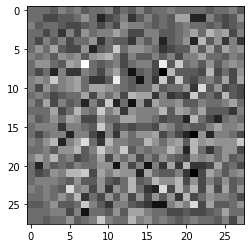

In [39]:
latent_dim = 100
input_shape = (latent_dim,)
output_shape = (28, 28, 1)

generator = make_generator_1_mnist(input_shape, output_shape)
print(generator.summary())

noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow(rescaler_mnist(generated_image[0, :, :, 0]), cmap='gray')

discriminator = make_discriminator_1_mnist(output_shape)
print(discriminator.summary())
decision = discriminator(generated_image)
print("decision {}".format(decision))

## Check models for Faces

Make generator and discriminator, generate a random image with the untrained generator, and predict with the discriminator if the generated image is real or not. 

### Model for faces 64x64

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
g_h0_lin (Dense)             (None, 16384)             1638400   
_________________________________________________________________
g_h0_lin_bn (BatchNormalizat (None, 16384)             65536     
_________________________________________________________________
g_h0_lin_a (LeakyReLU)       (None, 16384)             0         
_________________________________________________________________
g_h0_a (Reshape)             (None, 4, 4, 1024)        0         
_________________________________________________________________
g_h1 (Conv2DTranspose)       (None, 8, 8, 512)         13107200  
_________________________________________________________________
g_h1_bn (BatchNormalization) (None, 8, 8, 512)         20

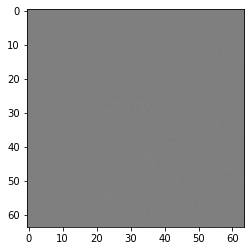

In [40]:
latent_dim = 100
input_shape = (latent_dim,)
output_shape = (64, 64, 3)

generator = make_generator_1_faces(input_shape, output_shape)
print(generator.summary())

noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow(rescaler_faces(generated_image[0]))

discriminator = make_discriminator_1_faces(output_shape)
print(discriminator.summary())
decision = discriminator(generated_image)
print(decision)

### Model for faces 32x32

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
g_h0_lin (Dense)             (None, 4096)              409600    
_________________________________________________________________
g_h0_lin_bn (BatchNormalizat (None, 4096)              16384     
_________________________________________________________________
g_h0_lin_a (LeakyReLU)       (None, 4096)              0         
_________________________________________________________________
g_h0_a (Reshape)             (None, 4, 4, 256)         0         
_________________________________________________________________
g_h1 (Conv2DTranspose)       (None, 8, 8, 256)         1638400   
_________________________________________________________________
g_h1_bn (BatchNormalization) (None, 8, 8, 256)         10

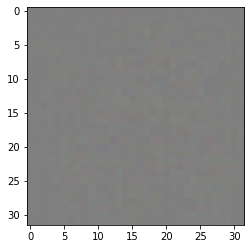

In [41]:
latent_dim = 100
input_shape = (latent_dim,)
output_shape = (32, 32, 3)

generator = make_generator_2_faces(input_shape, output_shape)
print(generator.summary())

noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow(rescaler_faces(generated_image[0]))

discriminator = make_discriminator_2_faces(output_shape)
print(discriminator.summary())
decision = discriminator(generated_image)
print(decision)

## Training utils

In [42]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled" (speeds up training).
@tf.function
def train_step(images, batch_size, latent_dim, generator, discriminator,
               cross_entropy, generator_optimizer, discriminator_optimizer):
    """ Train step. Exectued for every batch.

    Parameters
    ----------
    images : tf.Tensor
        Image batch of shape (batch_size, height, width, channels)
    batch_size : int
      The batch size (has to be same to what is used to batch the dataset in
      the data pipeline).
    latent_dim : int
      The latent vector dimension of the generator.
    generator : keras.Model
      The generator model.
    discriminator : keras.Model
      The discriminator model.
    cross_entropy : func
      Helper fucntion for binary cross-entropy so we do not have to always 
      instantiate one (RAM friendly, doesnt matter too much tho).
    generator_optimizer : keras.optimizers
      The generator optimizer.
    discriminator_optimizer : keras.optimizers
      The discriminator optimizer.

    Returns
    -------
    gen_loss : tf.Tensor
      The generator loss.
    disc_loss : tf.Tensor
      The discriminator loss.

    Raises
    ------
    None

    Notes
    -----
    None
    """
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator(random_latent_vectors, training=False)

    # Combine them with real images on axis=0 (i.e.: now have the generated
    # and the real images on one "line")
    combined_images = tf.concat([generated_images, images], axis=0)

    # Assemble labels discriminating real from fake images.
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((tf.shape(images)[0], 1))], axis=0
    )

    # Add random noise to the labels - important trick according to F.C.
    # https://keras.io/examples/generative/dcgan_overriding_train_step/
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    # Train the discriminator.
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images, training=True)
        disc_loss = cross_entropy(labels, predictions)
    
    # get and apply grads for discriminator
    grads = tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
        zip(grads, discriminator.trainable_weights)
    )

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors, 
                                              training=True), 
                                    training=False)
        gen_loss = cross_entropy(misleading_labels, predictions)
    
    # get and apply grads for generator
    grads = tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

    return gen_loss, disc_loss

def fid_step(batch_size, latent_dim, generator, images, fid_scorer):
    """ FID step. Exectued for every batch in the FID test set if wanted.

    Parameters
    ----------
    batch_size : int
    The batch size.
    latent_dim : int
    The latent vector dimension of the generator.
    generator : keras.Model
    The generator model.
    images : tf.Tensor
    Image batch of shape (batch_size, width, height, channels).
    Note that the image batch is normalized, so the FID scorer takes care of 
    rescaling them to 0-255 before feeding them into the Inception model.
    fid_scorer : FID
    FID score computer.

    Returns
    -------
    None

    Raises
    ------
    None

    Notes
    -----
    Note that the image batch is normalized, so the FID scorer takes care of 
    rescaling them to 0-255 before feeding them into the Inception model.
    Also note that the FID can only be computed for images with 3 channels.
    """
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator(random_latent_vectors, training=False)

    # convert tf.Tensor image batch to np.ndarray
    generated_images_np = generated_images.numpy()
    images_np = images.numpy()

    # compute the fid score (apply_rescaler has to be true if the images
    # are pre-processed with a normalizer)
    fid_score = fid_scorer(generated_images_np, images_np, apply_rescaler=True)

    return fid_score


def train(dataset, gen_loss_metric, disc_loss_metric,
          train_summary_writer, gen_summary_writer,
          epochs, batch_size, latent_dim, generator, discriminator, 
          cross_entropy, generator_optimizer, discriminator_optimizer, 
          seed, viz_save_path, checkpoint_prefix, dataset_name, dataset_size,
          rescaler, ckpt_save_epoch, **fid_dict):
    """ Train loop for training a DCGAN model with a generator and a 
    discriminator.

    Parameters
    ----------
    dataset : tf.Dataset
      The dataset, pre-processed, shuffled, batched, pre-fetched. 
    gen_loss_metric : keras.Metrics
    Generator loss metric for logging and averaging over batches for an 
    epoch estimate.
    disc_loss_metric : keras.Metrics
    Disciminator loss metric for logging and averaging over batches for an 
    epoch estimate.
    train_summary_writer : tf.summary.SummaryWriter
    For training Tensrboard logs.
    gen_summary_writer : tf.summary.SummaryWriter
    For generated images Tensrboard logs.
    epochs : int
    Epochs.
    batch_size : int
    The batch size.
    latent_dim : int
    The latent vector dimension of the generator.
    generator : keras.Model
    The generator model.
    discriminator : keras.Model
    The discriminator model.
    cross_entropy : func
    Helper fucntion for binary cross-entropy so we do not have to always 
    instantiate one (RAM friendly, doesnt matter too much tho).
    generator_optimizer : keras.optimizers
    The generator optimizer.
    discriminator_optimizer : keras.optimizers
    The discriminator optimizer.
    seed : tf.Tensor
    Random seed for generating and inspecting progress on the same images.
    I.e.: same face or digit over epochs in visualization.
    viz_save_path : str
    Save path for generated images.
    checkpoint_prefix : str
    For checkpoints.
    dataset_name : str
    The dataset name. Herer for visualization reasons.
    dataset_size : int
    The datast size, here for tqdm stuff.
    rescaler : tf.keras.Preprocessing
    Invese of normlaizer for images, here for visualization reasons.
    ckpt_save_epoch : int
    Checkpoint save every n epochs.
    fid_dict : dict
    Contains stuff for computing FID if needed, such as:
    dataset_fid : tf.Dataset, Same as dataset, but only for FID.
    fid_size : int, Number of images for FID computation.
    fid_score_metric : keras.Metrics, Disciminator loss metric for logging 
    and averaging over batches for an epoch estimate.
    fid_scorer : FID, fid scorer object, has image rescaler with the inverse 
    rule of the image dataset normalizer

    Returns
    -------
    None

    Raises
    ------
    None

    Notes
    -----
    None
    """
    # if fid_dict is not empty
    # retrive here as it is used over epochs
    if fid_dict:
        fid_score_metric = fid_dict["fid_score_metric"]

    for epoch in range(epochs):
        print(f"epoch: {epoch+1}/{epochs}...")
        start = time.time()

        # tqdm stuff for loading bars
        pbar = tqdm(total=int(dataset_size/batch_size))
        pbar.set_description("batches")

        # mini-batch steps
        for image_batch in dataset:
            gen_loss, disc_loss = \
            train_step(image_batch, batch_size, latent_dim, 
                       generator, discriminator, cross_entropy,
                       generator_optimizer, discriminator_optimizer)

            # Update training metrics
            gen_loss_metric.update_state(gen_loss)
            disc_loss_metric.update_state(disc_loss)

            # tqdm render
            pbar.update(1)
            pbar.set_description(f"batches (g_l: {gen_loss_metric.result():.4f}, "
            f"d_l: {disc_loss_metric.result():.4f})")

        pbar.close()

        # if fid_dict is not empty
        # do mini-batch-based FID comptation on FID test set
        if fid_dict:
            dataset_fid = fid_dict["dataset_fid"]
            fid_size = fid_dict["fid_size"]
            fid_scorer = fid_dict["fid_scorer"]

            pbar = tqdm(total=int(fid_size/batch_size))
            pbar.set_description("fid batches")

            for image_batch in dataset_fid:
                fid_score = fid_step(batch_size, latent_dim, generator, image_batch, 
                                     fid_scorer)
                fid_score_metric.update_state(fid_score)
                pbar.update(1)
                pbar.set_description(f"fid batches (fid: {fid_score_metric.result():.4f}")

            pbar.close()

        # Save the model every ckpt_save_epoch epochs
        if_ckpt_save_epoch = (epoch + 1) % ckpt_save_epoch == 0
        if if_ckpt_save_epoch:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        fig = generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,
                                 viz_save_path,
                                 dataset_name,
                                 rescaler)

        # log to tensorboard the generated image grid
        with gen_summary_writer.as_default():
            tf.summary.image("generated_images", plot_to_image(fig), step=epoch)

        # log to tensorboard the training metrics
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss_metric', gen_loss_metric.result(), step=epoch)
            tf.summary.scalar('disc_loss_metric', disc_loss_metric.result(), step=epoch)
            if fid_dict:
                tf.summary.scalar('fid_score_metric', fid_score_metric.result(), step=epoch)

        # viz images (have to do it here, otherwise can break tensorboard)
        plt.show()

        # show training info
        if fid_dict:
            print(f"{epoch+1}/{epochs} ({time.time()-start:.4} s):\n"
                f"gen_loss_metric={gen_loss_metric.result()},\n"
                f"disc_loss_metric={disc_loss_metric.result()},\n" 
                f"fid_score_metric={fid_score_metric.result()}\n")
        else:
            print(f"{epoch+1}/{epochs} ({time.time()-start:.4} s):\n"
                f"gen_loss_metric={gen_loss_metric.result()},\n"
                f"disc_loss_metric={disc_loss_metric.result()}\n")

        # Reset metrics every epoch
        # is this needed? -> yes
        gen_loss_metric.reset_states()
        disc_loss_metric.reset_states()
        if fid_dict:
            fid_score_metric.reset_states()

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed,
                           viz_save_path,
                           dataset_name,
                           rescaler)


def generate_and_save_images(model, epoch, test_input, viz_save_path, 
                             dataset_name, rescaler):
    # source: https://www.tensorflow.org/tutorials/generative/dcgan
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.grid(False)
        if dataset_name == "mnist":
            plt.imshow(rescaler(predictions[i, :, :, 0]), cmap='gray')
        elif dataset_name == "faces":
            plt.imshow(rescaler(predictions[i]))
        else:
            raise Exception(f"invalid dataset_name: {dataset_name}")
        plt.axis('off')

    plt.savefig(os.path.join(viz_save_path, f"epoch_{epoch:04d}.png"))
    #plt.show()

    return fig


def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.

    From: https://www.tensorflow.org/tensorboard/image_summaries
    """
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

## Train on MNIST

Train a DCGAN model with a generator and a discriminator to model digits in the MNIST dataset.

Note that the generator and the discriminator models can be changed by calling different ```make_generator_X_mnist``` and ```make_discriminator_X_mnist``` functions where ```X``` stands for the IDs of the generator and the corresponding discriminator architectures.

During training the following are saved:
- generated grid of images after each epoch at ```...dcgan/assets/experiment_id/```
- logs of generated grid of images after each epoch on Tensorboard and logs of training metrics such as generator and discrimator loss and FID metric at ```...dcgan/logs/experiment_id/gen/``` and ```...dcgan/logs/experiment_id/train/```, respectively
- training checkpoints at ```...dcgan/training_checkpoints/experiment_id/```
- final saved ```keras.Model``` objects of the generator and the discriminator at ```...dcgan/saved_models/generator/experiment_id/``` and ```...dcgan/saved_models/discriminator/experiment_id/```, respectively

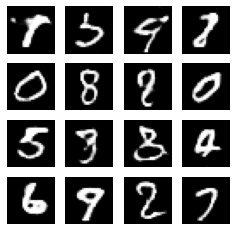

In [43]:
# get image normalizer and inverse normlaizer
image_normalizer_typ = "tanh"
normalizer_mnist = image_normalizer(image_normalizer_typ)
rescaler_mnist = image_rescaler(image_normalizer_typ)

# load dataset (shuffled, pre-processed, batched, and pre-fetched)
# original shape = (28, 28, 1)
resize_to = None
kwargs = {"data_directory": None, 
          "resize_to": resize_to,
          "reduce_to": None,
          "normalizer": normalizer_mnist}
dataset_name = "mnist"
batch_size = 64
dataset, dataset_size = data_pipeline_load(dataset_name, **kwargs)    
dataset, dataset_size, _, _ = \
  data_pipeline_pre_train(dataset, dataset_size, batch_size, fid_split=0.0)

# tensorboard logs are saved here
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
experiment_id = current_time + "-" + dataset_name
log_dir = os.path.join(base_path, 'logs', experiment_id)
os.makedirs(log_dir, exist_ok=True)

train_log_dir = os.path.join(log_dir, "train")
gen_log_dir = os.path.join(log_dir, "gen")
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)

# training chekcpoints are saved here
checkpoint_dir = os.path.join(base_path, 'training_checkpoints', experiment_id)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# generated images are saved here
viz_save_path = os.path.join(base_path, "assets", experiment_id)
os.makedirs(viz_save_path, exist_ok=True)

# full saved models come here
saved_generator_dir = \
  os.path.join(base_path, 'saved_models', "generator", experiment_id)
saved_generator_path = \
  os.path.join(saved_generator_dir, "generator.h5")
saved_discriminator_dir = \
  os.path.join(base_path, 'saved_models', "discriminator", experiment_id)
saved_discriminator_path = \
  os.path.join(saved_discriminator_dir, "discriminator.h5")

# make generator and discriminator
latent_dim = 100
input_shape = (latent_dim,)
output_shape = (28, 28, 1)
generator = make_generator_1_mnist(input_shape, output_shape)
discriminator = make_discriminator_1_mnist(output_shape)

# make optimizers
generator_optimizer = \
  tf.keras.optimizers.Adam(learning_rate=1e-4, 
                           beta_1=0.9, 
                           beta_2=0.999, 
                           epsilon=1e-07)
  
discriminator_optimizer = \
  tf.keras.optimizers.Adam(learning_rate=1e-4, 
                           beta_1=0.9, 
                           beta_2=0.999, 
                           epsilon=1e-07)

# make training metrics
gen_loss_metric = tf.keras.metrics.Mean('gen_loss_metric', dtype=tf.float32)
disc_loss_metric = tf.keras.metrics.Mean('disc_loss_metric', dtype=tf.float32)

# make checkpint saver callback
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# cross-entropy helper
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# some config
epochs = 50
# as defined before for loading and batching the dataset
assert batch_size == 64
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, latent_dim])

# save the params every n epochs
ckpt_save_epoch = 1

# FID cannot be compute for digits due to the 3-channel image 
# requirement of the Inception model
fid_dict = {}

# train
train(dataset=dataset,
      gen_loss_metric=gen_loss_metric, 
      disc_loss_metric=disc_loss_metric, 
      train_summary_writer=train_summary_writer, 
      gen_summary_writer=gen_summary_writer, 
      epochs=epochs, 
      batch_size=batch_size, 
      latent_dim=latent_dim, 
      generator=generator, 
      discriminator=discriminator,
      cross_entropy=cross_entropy, 
      generator_optimizer=generator_optimizer, 
      discriminator_optimizer=discriminator_optimizer, 
      seed=seed, 
      viz_save_path=viz_save_path, 
      checkpoint_prefix=checkpoint_prefix, 
      dataset_name=dataset_name,
      dataset_size=dataset_size,
      rescaler=rescaler_mnist, 
      ckpt_save_epoch=ckpt_save_epoch,
      **fid_dict)

# save full models
generator.save(saved_generator_path)
discriminator.save(saved_discriminator_path)

### Visualize training metrics and generated images on Tensorboard

The code cell below will open Tensorboard within this colab. The same things can be visualizer outside of the notebook if needed.

```tensorboard --log_dir logs```

### Load trained models to generate images

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
generator_re = tf.keras.models.load_model(saved_generator_path)
discriminator_re = tf.keras.models.load_model(saved_discriminator_path)

# inspect models
print(generator_re.summary())
print(discriminator_re.summary())

# same values as for training
latent_dim = 100
input_shape = (latent_dim,)
output_shape = (28, 28, 1)

# random latent vector to generate images from
noise = tf.random.normal([1, latent_dim])
generated_image = generator_re(noise, training=False)

# show images generated with the trained model
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# show the trained discrimiator's predicition of the generated image 
decision = discriminator_re(generated_image)
print(decision)

## Train on Faces

Train a DCGAN model with a generator and a discriminator to model faces in the CelebA dataset.

Note that the generator and the discriminator models can be changed by calling different ```make_generator_X_faces``` and ```make_discriminator_X_faces``` functions where ```X``` stands for the IDs of the generator and the corresponding discriminator architectures. Note that the faces data maybe resized from its original size (e.g.: 64x64 or 32x32) for which a new model pai should be written.

During training the following are saved:
- generated grid of images after each epoch at ```...dcgan/assets/experiment_id/```
- logs of generated grid of images after each epoch on Tensorboard and logs of training metrics such as generator and discrimator loss and FID metric at ```...dcgan/logs/experiment_id/gen/``` and ```...dcgan/logs/experiment_id/train/```, respectively
- training checkpoints at ```...dcgan/training_checkpoints/experiment_id/```
- final saved ```keras.Model``` objects of the generator and the discriminator at ```...dcgan/saved_models/generator/experiment_id/``` and ```...dcgan/saved_models/discriminator/experiment_id/```, respectively

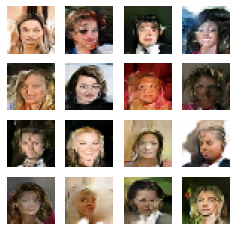

In [14]:
# get image normalizer and inverse normlaizer
image_normalizer_typ = "tanh"
normalizer_faces = image_normalizer(image_normalizer_typ)
rescaler_faces = image_rescaler(image_normalizer_typ)

# load dataset (shuffled, pre-processed, batched, and pre-fetched)
# original shape = (218, 178, 3)
resize_to = (32, 32)
kwargs = {"data_directory": data_directory_faces, 
          "resize_to": resize_to,
          "reduce_to": None,
          "normalizer": normalizer_faces}

dataset_name = "faces"
batch_size = 64
dataset, dataset_size = data_pipeline_load(dataset_name, **kwargs)    
dataset, dataset_size, dataset_fid, fid_size = \
  data_pipeline_pre_train(dataset, dataset_size, batch_size, fid_split=0.005)


# tensorboard logs are saved here
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
experiment_id = current_time + "-" + dataset_name
log_dir = os.path.join(base_path, 'logs', experiment_id)
os.makedirs(log_dir, exist_ok=True)

train_log_dir = os.path.join(log_dir, "train")
gen_log_dir = os.path.join(log_dir, "gen")
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)

# training chekcpoints are saved here
checkpoint_dir = os.path.join(base_path, 'training_checkpoints', experiment_id)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# generated images are saved here
viz_save_path = os.path.join(base_path, "assets", experiment_id)
os.makedirs(viz_save_path, exist_ok=True)

# full saved models come here
saved_generator_dir = \
  os.path.join(base_path, 'saved_models', "generator", experiment_id)
saved_generator_path = \
  os.path.join(saved_generator_dir, "generator.h5")
saved_discriminator_dir = \
  os.path.join(base_path, 'saved_models', "discriminator", experiment_id)
saved_discriminator_path = \
  os.path.join(saved_discriminator_dir, "discriminator.h5")

# make generator and discriminator
latent_dim = 100
input_shape = (latent_dim,)
output_shape = (32, 32, 3)
generator = make_generator_2_faces(input_shape, output_shape)
discriminator = make_discriminator_2_faces(output_shape)

# make optimizers
learning_rate = 1e-4
beta_1 = 0.9

generator_optimizer = \
  tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                           beta_1=beta_1, 
                           beta_2=0.999, 
                           epsilon=1e-07)
  
discriminator_optimizer = \
  tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                           beta_1=beta_1, 
                           beta_2=0.999, 
                           epsilon=1e-07)

# make training metrics
gen_loss_metric = tf.keras.metrics.Mean('gen_loss_metric', dtype=tf.float32)
disc_loss_metric = tf.keras.metrics.Mean('disc_loss_metric', dtype=tf.float32)

# make checkpint saver callback
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# cross-entropy helper
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# some config
epochs = 75
# as defined before for loading and batching the dataset
assert batch_size == 64
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, latent_dim])

# FID
use_fid = True

if use_fid:
    fid_scorer = FID(rescaler=rescaler_faces)
    fid_score_metric = tf.keras.metrics.Mean('fid_score_metric', dtype=tf.float32)
    fid_dict = {
      "fid_scorer": fid_scorer, 
      "fid_score_metric": fid_score_metric,
      "dataset_fid": dataset_fid,
      "fid_size": fid_size
      }
else:
    fid_dict = {}

ckpt_save_epoch = 1

# train
print(f"experiment_id: {experiment_id}")

train(dataset=dataset,
      gen_loss_metric=gen_loss_metric, 
      disc_loss_metric=disc_loss_metric, 
      train_summary_writer=train_summary_writer, 
      gen_summary_writer=gen_summary_writer, 
      epochs=epochs, 
      batch_size=batch_size, 
      latent_dim=latent_dim, 
      generator=generator, 
      discriminator=discriminator,
      cross_entropy=cross_entropy, 
      generator_optimizer=generator_optimizer, 
      discriminator_optimizer=discriminator_optimizer, 
      seed=seed, 
      viz_save_path=viz_save_path, 
      checkpoint_prefix=checkpoint_prefix, 
      dataset_name=dataset_name,
      dataset_size=dataset_size,
      rescaler=rescaler_faces, 
      ckpt_save_epoch=ckpt_save_epoch,
      **fid_dict)

# save full models
generator.save(saved_generator_path)
discriminator.save(saved_discriminator_path)

### Visualize training metrics and generated images on Tensorboard

The code cell below will open Tensorboard within this colab. The same things can be visualizer outside of the notebook if needed.

```tensorboard --log_dir logs```

### Load trained models to generate images

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
generator_re = tf.keras.models.load_model(saved_generator_path)
discriminator_re = tf.keras.models.load_model(saved_discriminator_path)

print(generator_re.summary())
print(discriminator_re.summary())

latent_dim = 100
input_shape = (latent_dim,)

noise = tf.random.normal([1, latent_dim])
generated_image = generator_re(noise, training=False)

plt.imshow(rescaler(generated_image[0]))

decision = discriminator_re(generated_image)
print(decision)